In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# Gravitational Constant
G = 6.67430e-11

# Random direction helper
def random_direction_vector():
    vec = np.random.uniform(-1.0, 1.0, size=2)
    norm = np.linalg.norm(vec)
    return vec / norm if norm > 0 else np.array([1.0, 0.0])

# ODE definition
def two_body_ode(t, y, m1, m2):
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y
    dx, dy = x2 - x1, y2 - y1
    r = np.sqrt(dx**2 + dy**2) + 1e-10
    F = G * m1 * m2 / r**3
    fx, fy = F * dx, F * dy

    ax1, ay1 = fx / m1, fy / m1
    ax2, ay2 = -fx / m2, -fy / m2

    return [vx1, vy1, vx2, vy2, ax1, ay1, ax2, ay2]

# Run simulation
def simulate_final_positions(m1, m2, x1, x2, v1, v2, t_eval):
    y0 = np.concatenate([x1, x2, v1, v2])
    result = solve_ivp(
        fun=lambda t, y: two_body_ode(t, y, m1, m2),
        t_span=(0, t_eval),
        y0=y0,
        t_eval=[t_eval],
        rtol=1e-8,
        atol=1e-8
    )
    if not result.success:
        raise RuntimeError("ODE solver failed.")
    x1_final = result.y[:2, -1]
    x2_final = result.y[2:4, -1]
    return np.concatenate([x1_final, x2_final])

# Dataset generation and CSV writing
def generate_and_save_dataset_csv(filepath="combined_dataset.csv", num_samples=10000, t_max=1e6, seed=42):
    np.random.seed(seed)  # Set seed for reproducibility
    rows = []

    for _ in range(num_samples):
        try:
            m1 = 10**np.random.uniform(22, 26)
            m2 = 10**np.random.uniform(22, 26)

            x1 = np.random.uniform(-2e8, 2e8, size=2)
            direction = random_direction_vector()
            distance = np.random.uniform(1e8, 3e8)
            x2 = x1 + distance * direction

            v1 = np.random.uniform(-3e4, 3e4, size=2)
            v2 = -v1 * (m1 / m2) * np.random.uniform(0.9, 1.1)

            t = np.random.uniform(0.1 * t_max, t_max)
            target = simulate_final_positions(m1, m2, x1, x2, v1, v2, t)

            row = np.concatenate([
                [m1, m2], x1, x2, v1, v2, [t], target
            ])
            rows.append(row)
        except RuntimeError:
            continue

    columns = [
        'm1', 'm2',
        'x1', 'y1', 'x2', 'y2',
        'v1x', 'v1y', 'v2x', 'v2y',
        't',
        'x1_final', 'y1_final', 'x2_final', 'y2_final'
    ]

    df = pd.DataFrame(rows, columns=columns)
    df.to_csv(filepath, index=False)
    print(f"Dataset of {len(df)} samples saved to '{filepath}'.")

# Example usage
generate_and_save_dataset_csv(filepath="combined_dataset.csv", num_samples=10000, seed=123)


Dataset of 10000 samples saved to 'combined_dataset.csv'.


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === Dataset preparation ===

# Load CSV
df = pd.read_csv("combined_dataset.csv")

# Inputs: m1,m2,x1,y1,x2,y2,v1x,v1y,v2x,v2y,t
X = df[['m1', 'm2', 'x1', 'y1', 'x2', 'y2', 'v1x', 'v1y', 'v2x', 'v2y', 't']].values

# Targets: x1_final,y1_final,x2_final,y2_final
y = df[['x1_final', 'y1_final', 'x2_final', 'y2_final']].values

# Split dataset 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize features and targets using training set only
input_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_scaled = input_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train)

X_test_scaled = input_scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test)

# Dataset class
class StandardizedTwoBodyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        x_raw = x[:10]        # m1,m2,r1,r2,v1,v2
        t = x[10:11]          # time scalar
        y = self.y[idx]       # final positions
        return x_raw, t, y

train_dataset = StandardizedTwoBodyDataset(X_train_scaled, y_train_scaled)
test_dataset = StandardizedTwoBodyDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# === Model definition ===

#neural network which taked 11 inputs and provides 4 output data and has one hidden layer

class DirectTwoBodyPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(11, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # predicts [x1_final, y1_final, x2_final, y2_final]
        )

    def forward(self, x_raw, t):
        x = torch.cat([x_raw, t], dim=1)  # [batch, 11]
        return self.net(x)

# === Loss functions ===

G = 6.67430e-11  # gravitational constant (real units)

def ode_loss(x_raw, t, pred_pos, input_scaler, target_scaler):
    """
    Compute ODE residual loss in **original physical units**.
    x_raw: [B, 10] standardized inputs
    t: [B, 1] standardized time
    pred_pos: [B,4] standardized predicted final positions

    We unscale inputs and predictions before computing physics.
    """
    # Inverse scale inputs and outputs
    x_raw_np = x_raw.detach().cpu().numpy()
    pred_pos_np = pred_pos.detach().cpu().numpy()
    t_np = t.detach().cpu().numpy()

    # Reconstruct full inputs for inverse transform
    # We only inverse transform x_raw + t together because we scaled X including t column
    x_t_np = np.concatenate([x_raw_np, t_np], axis=1)
    x_t_orig = input_scaler.inverse_transform(x_t_np)

    # Split back original features
    m1 = torch.tensor(x_t_orig[:, 0], dtype=torch.float32).unsqueeze(-1)
    m2 = torch.tensor(x_t_orig[:, 1], dtype=torch.float32).unsqueeze(-1)
    r1_0 = torch.tensor(x_t_orig[:, 2:4], dtype=torch.float32)
    r2_0 = torch.tensor(x_t_orig[:, 4:6], dtype=torch.float32)
    v1_0 = torch.tensor(x_t_orig[:, 6:8], dtype=torch.float32)
    v2_0 = torch.tensor(x_t_orig[:, 8:10], dtype=torch.float32)
    t_orig = torch.tensor(x_t_orig[:, 10], dtype=torch.float32).unsqueeze(-1)

    # Unscale predictions
    pred_pos_orig = target_scaler.inverse_transform(pred_pos_np)
    pred_pos_orig = torch.tensor(pred_pos_orig, dtype=torch.float32)

    r1_t = pred_pos_orig[:, 0:2]
    r2_t = pred_pos_orig[:, 2:4]

    # Calculate estimated velocities and accelerations by finite difference
    v1_est = (r1_t - r1_0) / t_orig
    v2_est = (r2_t - r2_0) / t_orig

    a1_est = (v1_est - v1_0) / t_orig
    a2_est = (v2_est - v2_0) / t_orig

    # Compute gravitational force acceleration
    r12 = r2_t - r1_t
    dist = torch.norm(r12, dim=1, keepdim=True) + 1e-8
    force_mag = G * m1 * m2 / dist**3
    force_vec = force_mag * r12

    a1_phys = force_vec / m1
    a2_phys = -force_vec / m2

    # Residual loss (MSE)
    loss1 = (a1_est - a1_phys).pow(2).mean()
    loss2 = (a2_est - a2_phys).pow(2).mean()

    return (loss1 + loss2) / 2

def total_loss_fn(x_raw, t, y_true, pred_pos, input_scaler, target_scaler, lambda_ode=1e3):
    mse_loss = nn.MSELoss()(pred_pos, y_true)
    physics_loss = ode_loss(x_raw, t, pred_pos, input_scaler, target_scaler)
    return mse_loss + lambda_ode * physics_loss

# === Training ===

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DirectTwoBodyPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
lambda_ode = 1e3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x_raw, t, y_true in train_loader:
        x_raw, t, y_true = x_raw.to(device), t.to(device), y_true.to(device)
        pred = model(x_raw, t)
        loss = total_loss_fn(x_raw, t, y_true, pred, input_scaler, target_scaler, lambda_ode)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss / len(train_loader):.4e}")

# === Evaluation example: predict and invert scaling ===
from sklearn.metrics import mean_absolute_error

def evaluate_mae(model, data_loader, input_scaler, target_scaler, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x_raw, t, y_true in data_loader:
            x_raw, t, y_true = x_raw.to(device), t.to(device), y_true.to(device)
            preds_scaled = model(x_raw, t)

            # Convert scaled preds and targets back to original units (numpy)
            preds_np = preds_scaled.cpu().numpy()
            y_true_np = y_true.cpu().numpy()

            preds_orig = target_scaler.inverse_transform(preds_np)
            y_true_orig = target_scaler.inverse_transform(y_true_np)

            all_preds.append(preds_orig)
            all_targets.append(y_true_orig)

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    mae = mean_absolute_error(all_targets, all_preds)
    return mae


Epoch 1/50 - Loss: nan
Epoch 2/50 - Loss: nan
Epoch 3/50 - Loss: nan
Epoch 4/50 - Loss: nan
Epoch 5/50 - Loss: nan
Epoch 6/50 - Loss: nan
Epoch 7/50 - Loss: nan
Epoch 8/50 - Loss: nan
Epoch 9/50 - Loss: nan
Epoch 10/50 - Loss: nan
Epoch 11/50 - Loss: nan
Epoch 12/50 - Loss: nan
Epoch 13/50 - Loss: nan
Epoch 14/50 - Loss: nan
Epoch 15/50 - Loss: nan
Epoch 16/50 - Loss: nan
Epoch 17/50 - Loss: nan
Epoch 18/50 - Loss: nan
Epoch 19/50 - Loss: nan
Epoch 20/50 - Loss: nan
Epoch 21/50 - Loss: nan
Epoch 22/50 - Loss: nan
Epoch 23/50 - Loss: nan
Epoch 24/50 - Loss: nan
Epoch 25/50 - Loss: nan
Epoch 26/50 - Loss: nan
Epoch 27/50 - Loss: nan
Epoch 28/50 - Loss: nan
Epoch 29/50 - Loss: nan
Epoch 30/50 - Loss: nan
Epoch 31/50 - Loss: nan
Epoch 32/50 - Loss: nan
Epoch 33/50 - Loss: nan
Epoch 34/50 - Loss: nan
Epoch 35/50 - Loss: nan
Epoch 36/50 - Loss: nan
Epoch 37/50 - Loss: nan
Epoch 38/50 - Loss: nan
Epoch 39/50 - Loss: nan
Epoch 40/50 - Loss: nan
Epoch 41/50 - Loss: nan
Epoch 42/50 - Loss: nan
E

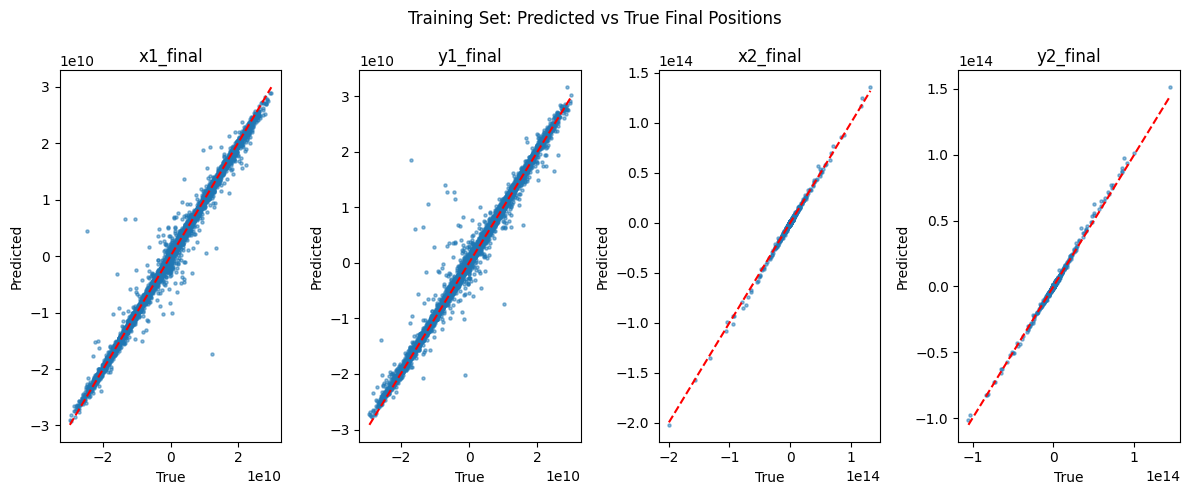

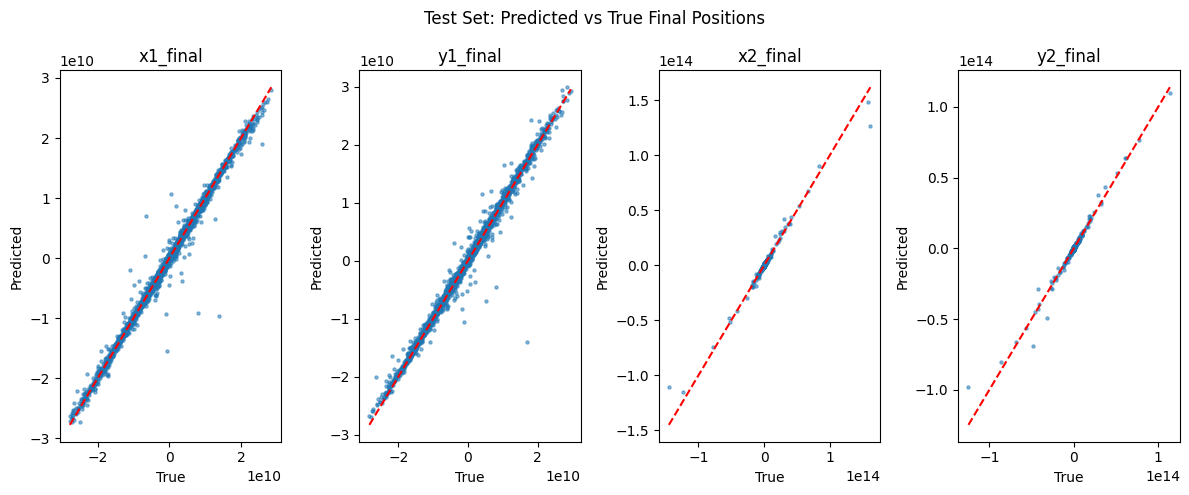

Training R² score: 0.9915
Testing R² score: 0.9817


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def get_preds_and_targets(model, data_loader, target_scaler, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x_raw, t, y_true in data_loader:
            x_raw, t, y_true = x_raw.to(device), t.to(device), y_true.to(device)
            preds_scaled = model(x_raw, t)

            preds_np = preds_scaled.cpu().numpy()
            y_true_np = y_true.cpu().numpy()

            preds_orig = target_scaler.inverse_transform(preds_np)
            y_true_orig = target_scaler.inverse_transform(y_true_np)

            all_preds.append(preds_orig)
            all_targets.append(y_true_orig)

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    return all_preds, all_targets

def plot_pred_vs_true(preds, targets, title):
    plt.figure(figsize=(12,5))

    # Plot each final coordinate separately
    coords = ['x1_final', 'y1_final', 'x2_final', 'y2_final']
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.scatter(targets[:, i], preds[:, i], s=5, alpha=0.5)
        plt.plot([targets[:, i].min(), targets[:, i].max()],
                 [targets[:, i].min(), targets[:, i].max()], 'r--')
        plt.xlabel('True')
        plt.ylabel('Predicted')
        plt.title(coords[i])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def compute_r2_score(preds, targets):
    r2 = r2_score(targets, preds, multioutput='uniform_average')
    return r2

# Get predictions and targets
train_preds, train_targets = get_preds_and_targets(model, train_loader, target_scaler, device)
test_preds, test_targets = get_preds_and_targets(model, test_loader, target_scaler, device)

# Plot train and test
plot_pred_vs_true(train_preds, train_targets, "Training Set: Predicted vs True Final Positions")
plot_pred_vs_true(test_preds, test_targets, "Test Set: Predicted vs True Final Positions")

# Compute and print R2
r2_train = compute_r2_score(train_preds, train_targets)
r2_test = compute_r2_score(test_preds, test_targets)
print(f"Training R² score: {r2_train:.4f}")
print(f"Testing R² score: {r2_test:.4f}")



Assumed that total momentum = 0 to minimize deviation as if the total momentum is not zero the center of mass will continue to move in some direction making it difficult for the model to observe patterns

The motion is purely internal, due to mutual gravity
The dataset is chosen to match that of real space problems

The data is scaled for better training




NameError: name 'scaler_X' is not defined